## Loading and preprocessing

In [23]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import seaborn as sns


In [24]:
from google.colab import drive 
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
test_csv = pd.read_csv ("/content/drive/My Drive/competitions/dataset/test.csv")
train_csv = pd.read_csv ("/content/drive/My Drive/competitions/dataset/train1.csv")

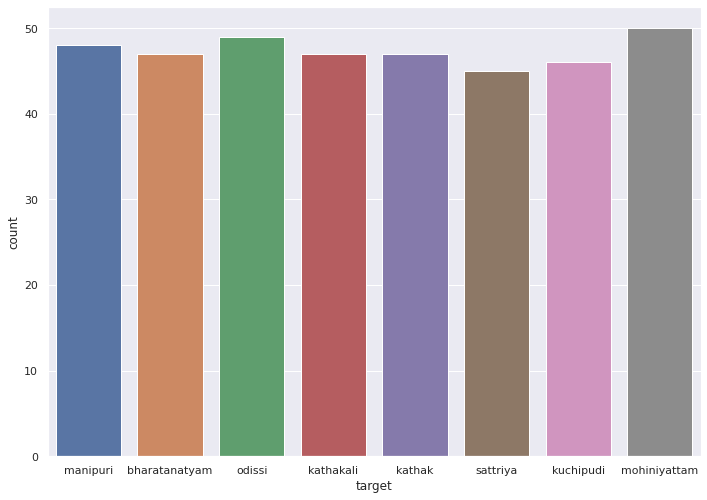

In [26]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.countplot(x='target',data = train_csv)


creating integer target values

In [27]:
from sklearn.preprocessing import LabelEncoder
lab_encoder = LabelEncoder()

In [28]:
lab_encoder.fit(train_csv.target.unique())
classes = lab_encoder.classes_

In [29]:
integer_targets = lab_encoder.fit_transform(train_csv.target)

In [30]:
classes

array(['bharatanatyam', 'kathak', 'kathakali', 'kuchipudi', 'manipuri',
       'mohiniyattam', 'odissi', 'sattriya'], dtype=object)

In [31]:
integer_targets

array([4, 0, 6, 2, 6, 1, 7, 3, 7, 3, 3, 3, 1, 7, 2, 6, 7, 3, 4, 1, 4, 0,
       3, 3, 5, 6, 1, 6, 6, 7, 2, 1, 2, 7, 0, 1, 0, 2, 6, 6, 6, 3, 4, 5,
       5, 6, 1, 4, 1, 5, 6, 7, 7, 6, 3, 7, 5, 4, 7, 1, 6, 7, 4, 2, 7, 2,
       4, 0, 1, 1, 7, 0, 2, 1, 5, 4, 1, 3, 6, 3, 0, 3, 0, 7, 1, 3, 5, 4,
       5, 0, 6, 3, 6, 3, 0, 5, 0, 0, 7, 1, 2, 5, 7, 0, 6, 1, 7, 7, 3, 6,
       1, 4, 2, 0, 5, 2, 3, 4, 5, 0, 5, 1, 2, 3, 0, 5, 0, 5, 2, 0, 5, 0,
       4, 4, 7, 5, 7, 0, 6, 5, 6, 5, 2, 6, 7, 0, 5, 6, 7, 4, 7, 7, 1, 6,
       2, 0, 5, 1, 3, 4, 7, 2, 5, 2, 1, 7, 5, 0, 0, 3, 6, 1, 6, 3, 5, 3,
       6, 7, 0, 0, 2, 6, 5, 4, 6, 2, 5, 5, 3, 1, 5, 4, 6, 6, 3, 2, 0, 2,
       5, 0, 2, 5, 6, 4, 3, 0, 7, 3, 2, 5, 2, 7, 5, 1, 3, 5, 3, 7, 5, 1,
       5, 7, 6, 1, 1, 2, 5, 5, 7, 1, 0, 1, 4, 2, 7, 4, 3, 4, 1, 0, 1, 3,
       2, 2, 6, 3, 0, 2, 3, 2, 6, 0, 7, 7, 1, 0, 6, 7, 0, 6, 7, 5, 2, 2,
       3, 3, 6, 4, 6, 7, 1, 6, 4, 0, 3, 0, 7, 5, 4, 0, 2, 5, 0, 1, 2, 3,
       0, 2, 5, 2, 3, 7, 7, 5, 2, 7, 7, 3, 4, 2, 4,

In [32]:
len(integer_targets)

379

splitting dataset 

In [35]:
#spent like an hour on this error
# -- failed to forget resetting indexes (solution: used values instead of pandas)
X_train, X_val, y_train, y_val = train_test_split( train_csv.Image.values, integer_targets, test_size=0.15, random_state=2020)

## creating datasets

In [36]:
class DanceDataset(Dataset):
    def __init__(self, images_names, labels, root_dir=None, transforms= None, is_train=True ):
        self.images_names = images_names
        if is_train == True:
            self.labels = labels
        else:
            self.labels = None
        self.root_dir = root_dir
        self.transforms = transforms
        self.is_train= is_train

    def __len__(self):
        return len(self.images_names)

    def __getitem__(self, index ):
        image = Image.open(self.root_dir + str(self.images_names[index]))

        if self.transforms != None:
            image = self.transforms(image)

        if self.is_train == False: #test time
            return image

        target = self.labels[index]
        return image,target



transformations_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    # torchvision.transforms.RandomHorizontalFlip(),
    # torchvision.transforms.RandomVerticalFlip(),
    # torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


transformations_val = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


batch_size = 32
train_dataset = DanceDataset(X_train, y_train, root_dir="/content/drive/My Drive/competitions/dataset/train/", transforms=transformations_train)
train_loader = DataLoader(train_dataset,batch_size = batch_size, shuffle=True)

val_dataset = DanceDataset(X_val, y_val, root_dir="/content/drive/My Drive/competitions/dataset/train/", transforms=transformations_val)
val_loader = DataLoader(val_dataset,batch_size = batch_size, shuffle=True)

test_dataset = DanceDataset(test_csv.Image,labels= None, root_dir="/content/drive/My Drive/competitions/dataset/test/", transforms=transformations_val, is_train=False)
test_loader = DataLoader(test_dataset,batch_size = batch_size, shuffle=False)

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

models

# models

In [ ]:
model = torchvision.models.resnet101(pretrained=True)

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
model.fc = nn.Sequential(
    nn.Linear(2048,256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256,8)
)

In [20]:
# model.fc = nn.Sequential(
#     nn.Dropout(0.2),
#     nn.Linear(2048,256),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(256,8)
# )

In [41]:
for param in model.parameters():
    param.requires_grad = False

In [46]:
model= model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,base_lr=1e-4,max_lr=1e-2,step_size_up=160)

In [ ]:
# for param in optimizer.param_groups:
#     param['lr'] = 0.00001

training

### train

In [44]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        # scheduler.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Loss: %.3f | Acc: %.3f%% (%d/%d)'% (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


    print('\n Validation:')
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(val_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)   
        val_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Loss: %.3f | Acc: %.3f%% (%d/%d)'% (val_loss/(batch_idx+1), 100.*correct/total, correct, total))


In [50]:
for param in model.parameters():
    param.requires_grad = True

### epochs train

In [ ]:
# for i in range(15):
#     train(i)

In [ ]:
torch.save(
    {
        "weights:": model.state_dict(),
        "optim_state": optimizer.state_dict(),
        "result: ": "Loss: 0.137 | Acc: 97.368% (37/38)",
    }
    ,
    "model_snapshot_85pcLeaderboard.pt"

)

In [ ]:
m = torch.load("/content/model_snapshot_85pcLeaderboard.pt")

In [ ]:
model.load_state_dict(m['weights:'])
optimizer.load_state_dict(m["optim_state"])

In [ ]:
from sklearn.metrics import confusion_matrix

testing


In [ ]:
print('\n Testing:')
model.eval()

my_predictions = []

for batch_idx, inputs in enumerate(test_loader):
    inputs = inputs.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)

    _, predicted = outputs.max(1)
    print(predicted)
    my_predictions.append(predicted)

In [ ]:
sub_list = []  
for elem in my_predictions:
    for val in elem:
        sub_list.append(val.item())

In [ ]:
pred_dance = lab_encoder.inverse_transform(sub_list)

In [ ]:
submission_csv = pd.DataFrame(test_csv)

In [ ]:
submission_csv["target"] = pred_dance

In [ ]:
submission_csv.to_csv("my_predictions_85pc.csv",index=False)